In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

import pandas

import numpy as np

import re

#from pushover import notify
from sksq96Utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

#%load_ext autoreload
#%autoreload 2

In [2]:
# Device configuration
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [3]:
bs = 32



In [4]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        esp = esp.to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    


In [5]:
image_channels = 3
model = VAE(image_channels=image_channels).to(device)
model.load_state_dict(torch.load('vae.torch', map_location=device))
model=model.to(device)

In [6]:
from torch.utils.data import DataLoader, Dataset
import glob




class CustomDatasetFromFile(Dataset):
    def __init__(self, folder_path):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms

        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = glob.glob(folder_path+'*')
        # Calculate len
        self.data_len = len(self.image_list)
        self.num_samples = self.data_len
        
        
        


    def __getitem__(self, index):
        from PIL import Image
        # Get image name from the pandas df
        single_image_path = self.image_list[index]
        
        ImageNameDataList = single_image_path[39:-4].split("_")
        imageGroupNumber = ImageNameDataList[0]
        imageFrameNumber = ImageNameDataList[1]
        prevFrameNumber = max(1,int(imageFrameNumber)-1)
        
        previous_image_path2 = glob.glob(f'D:/Kris\'s Workbench/FYP/TrainingData/0/'+str(imageGroupNumber)+'_'+str(prevFrameNumber)+'_'+'*')[0]
            
        # Open image
        im_as_im = Image.open(single_image_path)
        previousim_as_im = Image.open(previous_image_path2)
        
        
        
        preprocess=transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(), 
            ])
        im_preprocessed = preprocess(im_as_im)
        previousim_preprocessed = preprocess(previousim_as_im)
        
        return (im_preprocessed,previousim_preprocessed,ImageNameDataList[2:5])

    def __len__(self):
        return len(self.image_list)

In [7]:
dataset = CustomDatasetFromFile(folder_path=f'D:/Kris\'s Workbench/FYP/TrainingData/0/')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


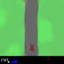

In [8]:
# Fixed input for debugging
CurrentImage, PreviousImage, _ = next(iter(dataloader))
curr, _, _ = model.encode(CurrentImage.to(device))
prev, _, _ = model.encode(PreviousImage.to(device))
concatenatedTensor = torch.cat((prev, curr), 0)

def decodeConcatenatedTensor(Tensor):
    a, b = concatenatedTensor.split(32, dim=0)
    aDecoded = model.decode(a)
    bDecoded = model.decode(b)
    save_image(aDecoded[0], 'imagea.png')
    save_image(aDecoded[0], 'imageb.png')
    


decodeConcatenatedTensor(concatenatedTensor)
from IPython.display import Image
Image(filename='imagea.png')

# print(a.shape)
# print(b.shape)
# recon_images = model.decode(b)
# save_image(recon_images[0], 'test_image.png')
# from IPython.display import Image
# Image(filename='test_image.png')


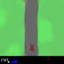

In [9]:

Image(filename='imageb.png')

In [12]:
#Neural Network Parameters
num_epochs = 5
batch_size = bs
learning_rate = 0.001

input_size = 64*32 #Dimensions of the input "concatenatedTensor"
hidden_size = 600
num_classes = 3 #Three state outputs. Acceleration. Braking. Turning Angle

print(concatenatedTensor.shape)

#Define neural network for this part
class StateDetectionNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(StateDetectionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() #Do we use RelU because linear maths is fast on gpu? Or is there some other benefit over sigmoid / alternatives?
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x.reshape(-1,input_size))
        out = self.relu(out)
        out = self.fc2(out)
        return out

model2 = StateDetectionNet(input_size, hidden_size, num_classes).to(device)

#Define loss and optimizer
loss = nn.CrossEntropyLoss()#mean squared error or l1 loss
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)  

torch.Size([64, 32])


In [15]:
#Training
for epoch in range(num_epochs):
    for idx, (CurrentImage, PreviousImage, statevariables) in enumerate(dataloader):
        CurrentImage = CurrentImage.to(device)
        PreviousImage = PreviousImage.to(device)
        curr, _, _ = model.encode(CurrentImage.to(device))
        prev, _, _ = model.encode(PreviousImage.to(device))
        concatenatedTensor = torch.cat((prev, curr), 0)
        
        out = model2(concatenatedTensor)
        loss = loss(out, statevariables)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #to_print = "Loss: {:.3f} {:.3f} {:.3f}".format(loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
        
        #
    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
    print(to_print)
    #print(epoch)

# notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'CurrentConditions.torch')

AttributeError: 'list' object has no attribute 'stack'